In [21]:
import pandas as pd
import numpy as np 
import matplotlib as plt

# models 
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.ensemble import RandomForestClassifier

# model selection
from sklearn.model_selection import GridSearchCV

#metrics
from sklearn.metrics import precision_score, classification_report, confusion_matrix,f1_score
from sklearn.model_selection import RepeatedStratifiedKFold

#smote 
from imblearn.over_sampling import SMOTE

# data
from sklearn.model_selection import train_test_split

#ignoring warnings
import warnings
warnings.filterwarnings('ignore')

# Models
from sklearn.ensemble import GradientBoostingClassifier

In [22]:
from yellowbrick.model_selection import validation_curve 
from sklearn.ensemble import RandomForestClassifier


In [23]:
from sklearn.neural_network import MLPClassifier

# Data Import and Split 

In [24]:
Train = pd.read_csv(r'../data/Train_year.csv', index_col=0)
y_Train = pd.read_csv(r'../data/y_Train_year.csv', index_col= 0)

Test = pd.read_csv(r'../data/Test_year.csv', index_col= 0)
y_Test = pd.read_csv(r'../data/y_Test_year.csv', index_col= 0)

In [25]:
Train.columns

Index(['ADR', 'Adults', 'ArrivalDateWeekNumber', 'BookingChanges', 'Children',
       'DaysInWaitingList', 'LeadTime', 'PreviousBookingsNotCanceled',
       'RequiredCarParkingSpaces', 'PreviousCancellations',
       'PreviousCancellationRate', 'StaysInWeekendNights', 'StaysInWeekNights',
       'TotalOfSpecialRequests', 'ArrivalDateYear', 'x0_BB', 'x0_SC', 'x1_A',
       'x1_B', 'x1_D', 'x1_E', 'x1_F', 'x1_G', 'x2_avg_booker',
       'x2_good_booker', 'x2_low_booker', 'x2_no_booker', 'x2_super_booker',
       'x3_Autumn', 'x3_Spring', 'x3_Summer', 'x4_Low_Season',
       'x5_frequent_foreigners', 'x5_portuguese', 'x5_regular_foreigners'],
      dtype='object')

In [26]:
# from feature selection variables: 
features = ['ADR', 'LeadTime','StaysInWeekNights', 'TotalOfSpecialRequests',
        'BookingChanges', 'PreviousBookingsNotCanceled', 'RequiredCarParkingSpaces', 'PreviousCancellations',
        'x0_BB', 'x0_SC', 'x1_A', 'x1_B', 'x1_D',
       'x1_E', 'x1_F', 'x1_G', 'x2_avg_booker', 'x2_good_booker',
       'x2_low_booker', 'x2_no_booker', 'x2_super_booker', 'x3_Autumn',
       'x3_Spring', 'x3_Summer', 'x4_Low_Season']

## Functions to Test Models 

In [27]:
def metrics(X_train, X_val, y_train, pred_train , y_val, pred_val, model):
    print('___________________________________________________________________________________________________________')
    print('                                                     TRAIN                                                 ')
    print('-----------------------------------------------------------------------------------------------------------')
    print(classification_report(y_train, pred_train))
    print(confusion_matrix(y_train, pred_train))
    print("Score: "+ str(model.score(X_train, y_train)))
    print("F1 Score: "+ str(f1_score(y_train, pred_train)))

    print('___________________________________________________________________________________________________________')
    print('                                                VALIDATION                                                 ')
    print('-----------------------------------------------------------------------------------------------------------')
    print(classification_report(y_val, pred_val))
    print(confusion_matrix(y_val, pred_val))
    print("Score: "+ str(model.score(X_val, y_val)))
    print("F1 Score: "+ str(f1_score(y_val, pred_val)))

In [28]:
def avg_score(model, data_to_slice, y_to_slice, columns_to_use, smote = True, rsk_splits = 5, rspk_repeats = 5, feat_sel = False):
    # apply kfold
    skf = RepeatedStratifiedKFold(n_splits=rsk_splits, n_repeats=rspk_repeats)
    # create lists to store the results from the different models 
    score_train = []
    score_test = []
    f1_list = []
    precision_list = []
    tn_avg = 0
    fp_avg = 0
    fn_avg = 0
    tp_avg = 0
    count = 0
    flag = 0 # feat sel flag to not keep printing 

    for train_index, test_index in skf.split(data_to_slice[columns_to_use],y_to_slice):
        # get the indexes of the observations assigned for each partition
        X_train, X_val = data_to_slice[columns_to_use].iloc[train_index], data_to_slice[columns_to_use].iloc[test_index]
        y_train, y_val = y_to_slice.iloc[train_index], y_to_slice.iloc[test_index]
        
        # SMOTE É AQUI 
        if smote: 
            smote = SMOTE(random_state = 11)
            X_train, y_train = smote.fit_resample(X_train, y_train)


        # applies the model 
        model_fit = model.fit(X_train, y_train)
        # predicts training 
        y_pred_train =  model_fit.predict(X_train)
        #predicts validation 
        y_pred_val = model_fit.predict(X_val)


        if feat_sel is True: 
            if hasattr(model_fit, 'feature_importances_'):
                feat_imp = pd.Series(model_fit.feature_importances_, columns_to_use).sort_values(ascending=False)
                feat_imp.plot(kind='bar', title='Feature Importances')

            elif flag == 0: 
                flag = 1
                print("This model has no feat_sel attb")
            else: 
                continue
        # prints metric results         
        #metrics(X_train, X_val, y_train, y_pred_train, y_val, y_pred_val, model)



        tn, fp, fn, tp = confusion_matrix(y_val, y_pred_val).ravel()
        count += 1
        tn_avg += tn
        fp_avg += fp
        fn_avg += fn
        tp_avg += tp

        
        value_train = model.score(X_train, y_train)
        # check the mean accuracy for the test
        value_test = model.score(X_val,y_val)
        f1_score_val = f1_score(y_val, y_pred_val)
        prec_score = precision_score(y_val, y_pred_val)
        # append the accuracies, the time and the number of iterations in the corresponding list
        score_train.append(value_train)
        score_test.append(value_test)
        f1_list.append(f1_score_val)
        precision_list.append(prec_score)
        
  
    avg_train = round(np.mean(score_train),3)
    avg_test = round(np.mean(score_test),3)
    std_train = round(np.std(score_train),2)
    std_test = round(np.std(score_test),2)
    avg_f1 = round(np.mean(f1_list),3)
    std_f1 = round(np.std(f1_list),2)
    avg_precision = round(np.mean(precision_list),3)
    std_precision = round(np.std(precision_list),2)

    tn_avg = tn_avg / count
    fp_avg = fp_avg / count
    fn_avg = fn_avg / count
    tp_avg = tp_avg / count
    #print(confusion_matrix(y_val, y_pred_val))
    confmatrix = str(tp_avg)+ ' , ' + str(tn_avg) + ' \n ' + str(fp_avg) + ' , ' +  str(fn_avg)
    return str(avg_train) + '+/-' + str(std_train),\
            str(avg_test) + '+/-' + str(std_test) , str(avg_f1) + '+/-' + str(std_f1), str(avg_precision), confmatrix

## Decision Tree

In [72]:
dt_gini = DecisionTreeClassifier(criterion='gini')
dt_entropy = DecisionTreeClassifier(criterion='entropy')

### Split Criteria

In [73]:
avg_score(dt_gini, Train, y_Train, features,True,2,2)

('0.994+/-0.0',
 '0.739+/-0.0',
 '0.558+/-0.0',
 '0.527',
 '2716.75 , 9522.0 \n 2441.0 , 1871.25')

In [74]:
avg_score(dt_entropy, Train, y_Train, features,True,2,2)

('0.994+/-0.0',
 '0.738+/-0.0',
 '0.556+/-0.01',
 '0.524',
 '2717.5 , 9497.5 \n 2465.5 , 1870.5')

Entropy looks like the best choice although both criterias are very similar. 

### GridSearch

In [83]:
# tree params
param_grid = {
    'splitter': ['best', 'random'],
    'max_depth':range(5,16,2),
    'min_samples_split':range(700,900,20),
    'min_samples_leaf': range(80,200,30),
    'min_impurity_decrease' : [0.01,0.03,0.05]
}
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = dt_entropy, param_grid = param_grid, scoring = 'f1')

grid_search.fit(Train, y_Train)
grid_search.best_params_, grid_search.best_score_

({'max_depth': 9,
  'min_impurity_decrease': 0.03,
  'min_samples_leaf': 170,
  'min_samples_split': 760,
  'splitter': 'random'},
 0.48486123551289273)

In [84]:
dt_model = DecisionTreeClassifier(criterion='entropy', max_depth=9, min_impurity_decrease=0.01, min_samples_leaf=170, min_samples_split=760, splitter='random')

In [85]:
avg_score(dt_model, Train, y_Train, features,5,5)

('0.675+/-0.02',
 '0.718+/-0.07',
 '0.529+/-0.02',
 '0.537',
 '1042.28 , 3708.24 \n 1076.96 , 792.92')

## Gradient Boost 

In [86]:
from sklearn.ensemble import GradientBoostingClassifier

In [87]:
gbm0 = GradientBoostingClassifier(random_state=10)

#### Small FeatSel for this specific model 

('0.806+/-0.0',
 '0.794+/-0.01',
 '0.623+/-0.01',
 '0.633',
 '2819.75 , 10324.25 \n 1638.75 , 1768.25')

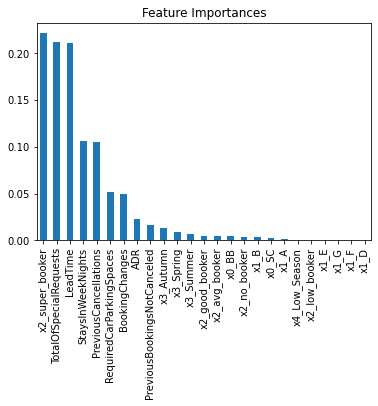

In [88]:
#Choose all predictors except target & IDcols
avg_score(gbm0, Train, y_Train, features,True,2,2, True)

#### GridSearch Exploring 

In [105]:
gb_feats = ['TotalOfSpecialRequests', 'x2_super_booker', 'LeadTime',
             'PreviousCancellationRate', 'StaysInWeekNights', 'ArrivalDateWeekNumber',
             'x3_Spring','RequiredCarParkingSpaces','ADR','BookingChanges']

In [90]:
# tree param - min_samples_split, min_samples_leaf, min_weight_fraction_leaf, max_depth, max_leaf_nodes, max_features
# boost param - learning_rate, n_estimators, subsample


In [92]:
# tree params
gbm1 = GradientBoostingClassifier(random_state=10)
param_grid = {
    'n_estimators':range(50,101,10)}
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = gbm1, param_grid = param_grid, scoring = 'f1')

grid_search.fit(Train, y_Train)
grid_search.best_params_, grid_search.best_score_

({'n_estimators': 90}, 0.1261832683319281)

In [82]:
#'max_depth':range(5,16,2),
#    'min_samples_split':range(200,1001,200),
#    'min_samples_leaf': range(80,200,30),
#    'learning_rate':[0.03,0.05,0.08,0.1]

In [94]:
# tree params
gbm1 = GradientBoostingClassifier(random_state=10, n_estimators=90,learning_rate=0.1)
param_grid = {
   'max_depth':range(5,16,2),
   'min_samples_split':range(200,1001,200),
   'min_samples_leaf': range(80,200,30)}
grid_search = GridSearchCV(estimator = gbm1, param_grid = param_grid, scoring = 'f1')

grid_search.fit(Train, y_Train)
grid_search.best_params_, grid_search.best_score_

({'max_depth': 15, 'min_samples_leaf': 170, 'min_samples_split': 800},
 0.09742415110205017)

('0.813+/-0.0',
 '0.798+/-0.01',
 '0.631+/-0.01',
 '0.638',
 '1146.04 , 4134.08 \n 651.12 , 689.16')

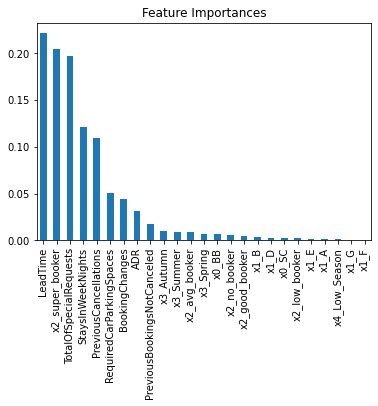

In [98]:
gbm1 = GradientBoostingClassifier(random_state=10,n_estimators=200)
avg_score(gbm1, Train, y_Train, features,5,5,feat_sel=True)

In [99]:
# tree params
gbm2 = GradientBoostingClassifier(random_state=10, n_estimators=200,learning_rate=0.1)
param_grid = {
   'max_depth':range(4,9,2),
   'min_samples_split':range(200,1001,200),
   'min_samples_leaf': range(80,200,30)}
grid_search = GridSearchCV(estimator = gbm1, param_grid = param_grid, scoring = 'f1')

grid_search.fit(Train, y_Train)
grid_search.best_params_, grid_search.best_score_

({'max_depth': 6, 'min_samples_leaf': 140, 'min_samples_split': 1000},
 0.10187617131900276)

In [ ]:
#0.64
# gbm3 = GradientBoostingClassifier(random_state=10,n_estimators=200,max_depth=6, min_samples_leaf=140, min_samples_split=2000, learning_rate=0.05)

In [35]:
gbm3 = GradientBoostingClassifier(random_state=10,n_estimators=200,max_depth=6, min_samples_leaf=140, min_samples_split=2000, learning_rate=0.05)


In [34]:
gbm3 = GradientBoostingClassifier(random_state=10,n_estimators=200,max_depth=6, min_samples_leaf=140, min_samples_split=2000, learning_rate=0.05)
avg_score(gbm3, Train, y_Train, Train.columns,5,5)

KeyboardInterrupt: 

In [108]:
gbm3 = GradientBoostingClassifier(random_state=10,n_estimators=200,max_depth=6, min_samples_leaf=140, min_samples_split=2000, learning_rate=0.05)
avg_score(gbm3, Train, y_Train, Train.columns,5,5)

('0.861+/-0.0',
 '0.815+/-0.0',
 '0.638+/-0.01',
 '0.696',
 '1081.24 , 4312.84 \n 472.36 , 753.96')

#### Final Algorithm

In [ ]:
gbm4 = GradientBoostingClassifier(random_state=10, learning_rate=0.1, max_features='sqrt',n_estimators=20, max_depth=5, min_samples_split=600, min_samples_leaf=30)

In [201]:
gbm3 = GradientBoostingClassifier(random_state=10,n_estimators=200,max_depth=6, min_samples_leaf=140, min_samples_split=2000, learning_rate=0.05)
avg_score(gbm3, Train, y_Train, Train.columns,5,5)

('0.87+/-0.0',
 '0.827+/-0.0',
 '0.691+/-0.01',
 '0.683',
 '1282.48 , 4190.12 \n 595.08 , 552.72')

('0.72+/-0.0',
 '0.52+/-0.01',
 '0.396+/-0.01',
 '0.376',
 '3339.6 , 7710.1 \n 5537.9 , 4656.4')

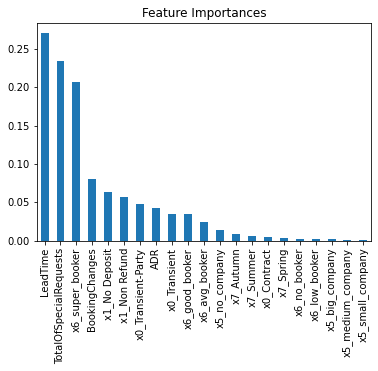

In [ ]:
avg_score(gbm4, Train, y_Train, features,2,2,feat_sel=True)

The gradient boost has very low capabilities of predicting the cancellation aspect. 

## Random Forest

In [29]:
# min_samples_leaf=60, min_samples_split=400

In [30]:
model_RFC1 = RandomForestClassifier(random_state=10, n_estimators=130, max_depth=15)
model_RFC2 = RandomForestClassifier(random_state=10, n_estimators=130, max_depth=15)

('0.903+/-0.0',
 '0.831+/-0.0',
 '0.704+/-0.01',
 '0.682',
 '1335.64 , 4163.76 \n 621.44 , 499.56')

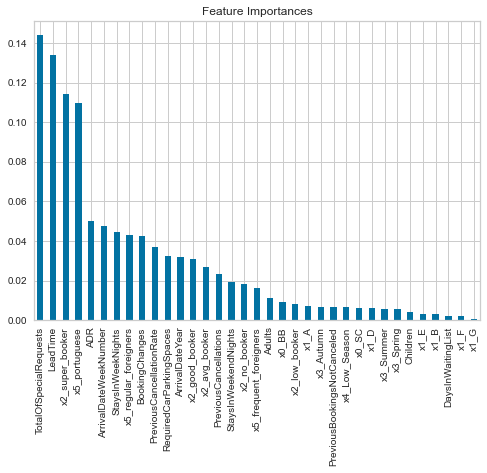

In [37]:
#Choose all predictors except target & IDcols
avg_score(model_RFC2, Train, y_Train, Train.columns,True,5,5, True)

In [122]:
# tree params
model_RFC = RandomForestClassifier(random_state=10)
param_grid = {
    'n_estimators':range(90,201,10)}
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = model_RFC, param_grid = param_grid, scoring = 'f1')

grid_search.fit(Train, y_Train)
grid_search.best_params_, grid_search.best_score_

({'n_estimators': 130}, 0.10088364157494692)

In [ ]:
# primeira hipotese 40
# segunda hipotese 15 -- melhor

#leaf
# 60 
# 90

#split
#400

In [39]:
def Test_models(model, Train, y_Train, Test, y_Test):
    model_fit = model.fit(Train, y_Train)
    y_pred_test = model_fit.predict(Test)
    a = 0
    ones = 0
    for i,x in enumerate(y_Test.IsCanceled):
        #print(i, y_pred_test[i],x)
        if y_pred_test[i] == x:
            a+=1
            if x == 1: 
                ones+=1
            
    print(classification_report(y_Test, y_pred_test))
    print(confusion_matrix(y_Test, y_pred_test))
    print(a)
    print(ones)
    

In [32]:
Test_models(model_RFC2, Train, y_Train, Test, y_Test)

              precision    recall  f1-score   support

           0       0.77      0.89      0.82     13183
           1       0.69      0.48      0.57      6826

    accuracy                           0.75     20009
   macro avg       0.73      0.68      0.69     20009
weighted avg       0.74      0.75      0.74     20009

[[11719  1464]
 [ 3560  3266]]
14985


In [41]:
Test_models(gbm3, Train, y_Train, Test, y_Test)

              precision    recall  f1-score   support

           0       0.77      0.88      0.82     13183
           1       0.68      0.51      0.58      6826

    accuracy                           0.75     20009
   macro avg       0.73      0.69      0.70     20009
weighted avg       0.74      0.75      0.74     20009

[[11584  1599]
 [ 3372  3454]]
15038
3454


## Neural Networks 

In [42]:
modelMLPC = MLPClassifier(random_state=10)

In [17]:
avg_score(modelMLPC, Train, y_Train, features,2,2)

('0.814+/-0.0',
 '0.766+/-0.01',
 '0.617+/-0.0',
 '0.567',
 '3112.5 , 9572.0 \n 2391.0 , 1475.5')

In [13]:
modelMLPC = MLPClassifier(random_state=10, hidden_layer_sizes=(50,60))

In [14]:
avg_score(modelMLPC, Train, y_Train, features,2,2)

('0.844+/-0.0',
 '0.744+/-0.01',
 '0.598+/-0.01',
 '0.531',
 '3147.9 , 9168.6 \n 2794.4 , 1440.1')

In [16]:
modelMLPC = MLPClassifier(random_state=10, hidden_layer_sizes=(100,))

In [45]:
Test_models(modelMLPC, Train[features], y_Train, Test[features], y_Test)

              precision    recall  f1-score   support

           0       0.75      0.86      0.80     13183
           1       0.62      0.46      0.53      6826

    accuracy                           0.72     20009
   macro avg       0.69      0.66      0.66     20009
weighted avg       0.71      0.72      0.71     20009

[[11275  1908]
 [ 3717  3109]]
14384
3109
